<h2><center><font color='blue'> Surface Reflectance

<h3><center><font color= 'teal'> Sushant Poudel

In [2]:
#import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu # To draw north arrow
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from matplotlib.colors import ListedColormap 
from rasterio.warp import transform_bounds
import glob
from rasterio.enums import Resampling
from rasterio.plot import show

In [2]:
path = "C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Project/Final Project/Surface_Reflectance"
os.chdir(path)

In [23]:
# List all tiff files (you can specify the directory where the files are located)

tiff_files = glob.glob("C:/Users/Sushant/OneDrive - Lamar University/1st semester/GIS/Project/Final Project/Surface_Reflectance/*.tif")  
src_files_to_mosaic = [rasterio.open(file) for file in tiff_files]
mosaic, out_trans = merge(src_files_to_mosaic)
output_file = "combined_raster.tif"
with rasterio.open(output_file, "w", driver="GTiff", count=1, dtype=mosaic.dtype,
                   crs=src_files_to_mosaic[0].crs, transform=out_trans,
                   width=mosaic.shape[2], height=mosaic.shape[1]) as dest:
    dest.write(mosaic[0], 1)  

for src in src_files_to_mosaic:
    src.close()

print(f"Combined raster saved as {output_file}")

Combined raster saved as combined_raster.tif


<H1>----------------------------------------------------------------------------------------</H1>

Using raster file: B7_2.tif


C:\Users\Sushant\AppData\Local\ipykernel_19020\1334356577.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = gdf.geometry.unary_union


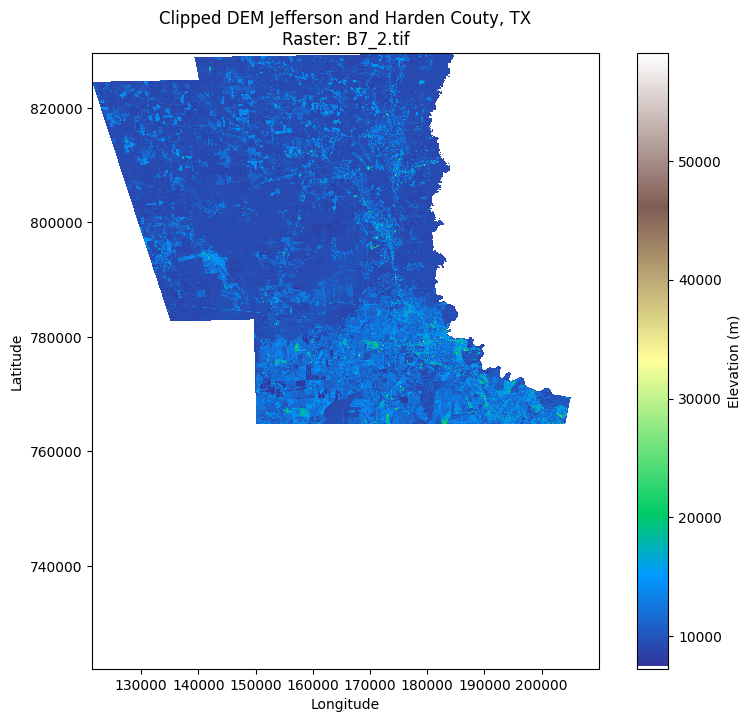

In [38]:
# Load the GeoDataFrame (city boundary from GeoPackage)
gpk_path = 'Jef_hard_combine_aea.gpkg'
gdf = gpd.read_file(gpk_path)
tif_files = glob.glob('*.tif')  
if not tif_files:
    raise FileNotFoundError("No .tif files found in the directory.")
raster_path = tif_files[0]  
print(f"Using raster file: {raster_path}")

# Open the raster file and process it
with rasterio.open(raster_path) as src:
    geo = gdf.geometry.unary_union
    out_image, out_transform = mask(src, [geo], crop=True, nodata=0)  
    out_metadata = src.profile.copy()
    out_metadata.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": 0  
    })
    
    clipped_raster_path = "clipped.tif"

    with rasterio.open(clipped_raster_path, 'w', **out_metadata) as dest:
        dest.write(out_image)

data = out_image[0]  
data_masked = np.where(data == 0, np.nan, data)  
terrain_cmap = plt.cm.terrain(np.linspace(0, 1, 256))  
terrain_cmap[0, :] = [1, 1, 1, 1]  
custom_cmap = ListedColormap(terrain_cmap)
min_x, min_y = out_transform * (0, data.shape[0]) 
max_x, max_y = out_transform * (data.shape[1], 0)  

# Plot the clipped DEM
plt.figure(figsize=(10, 8))
plt.imshow(data_masked, cmap=custom_cmap, extent=(min_x, max_x, min_y, max_y), interpolation="none")
plt.colorbar(label='Elevation (m)')  
plt.title(f'Clipped DEM Jefferson and Harden Couty, TX\nRaster: {raster_path}') 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<H1>Clip The DEM with the Combined County Boundary</H1>

C:\Users\Sushant\AppData\Local\ipykernel_19020\805822088.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geo = gdf.geometry.unary_union


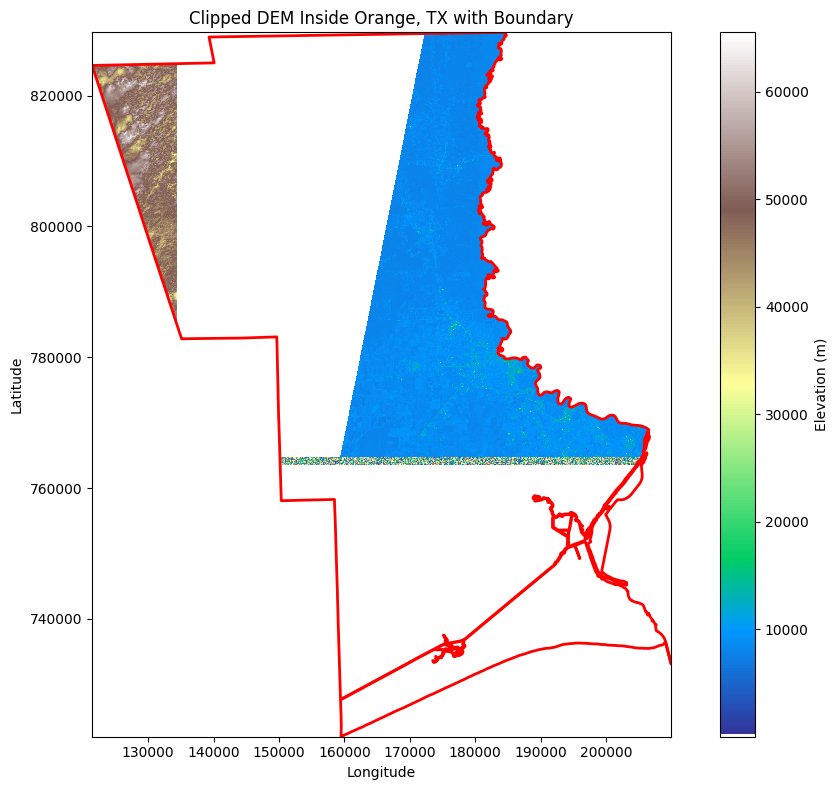

In [60]:
# Load the GeoDataFrame (city boundary from GeoPackage)
gpk_path = 'Jef_hard_combine_aea.gpkg'  
gdf = gpd.read_file(gpk_path)
raster_path = 'B2_1.tif'  

with rasterio.open(raster_path) as src:
    geo = gdf.geometry.unary_union
    out_image, out_transform = mask(src, [geo], crop=True, nodata=0)  # Set nodata value to 0
    out_metadata = src.profile.copy()
    out_metadata.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": 0 
    })
    clipped_raster_path = "clipped_dem_inside_orange.tif"

    with rasterio.open(clipped_raster_path, 'w', **out_metadata) as dest:
        dest.write(out_image)

data = out_image[0]  
data_masked = np.where(data == 0, np.nan, data)  
terrain_cmap = plt.cm.terrain(np.linspace(0, 1, 256)) 
terrain_cmap[0, :] = [1, 1, 1, 1] 
custom_cmap = ListedColormap(terrain_cmap)
min_x, min_y = out_transform * (0, data.shape[0]) 
max_x, max_y = out_transform * (data.shape[1], 0)   

# Plot the clipped DEM with the vector boundary overlaid
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data_masked, cmap=custom_cmap, extent=(min_x, max_x, min_y, max_y), interpolation="none")
gdf.boundary.plot(ax=ax, color='red', linewidth=2)
plt.colorbar(im, label='Elevation (m)', ax=ax) 
plt.title('Clipped DEM Inside Orange, TX with Boundary') 
plt.xlabel('Longitude')  
plt.ylabel('Latitude') 
plt.tight_layout()
plt.show()

In [55]:
# List all .tif files in the current directory
tif_files = glob.glob('*.tif')  
bands = {}

for tif_file in tif_files:
    parts = tif_file.split('_')
    if len(parts) == 2:  
        band = parts[0]  
        date = parts[1].replace('.tif', '')  
    else:        
        continue  
    if band not in bands:
        bands[band] = []  
    bands[band].append(tif_file)
for band, files in bands.items():
    print(f"{band} band files: {files}")

<H1>Caculation of Indices For Winter </H1>

Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: B4_1.tif, B5_1.tif, B2_1.tif, B6_1.tif, and B7_1.tif


C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:3: RuntimeWarning: invalid value encountered in divide
  return (band5 - band4) / (band5 + band4)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:6: RuntimeWarning: divide by zero encountered in divide
  return 2.5 * (band5 - band4) / (band5 + 6 * band4 - 7.5 * band2 + 1)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:15: RuntimeWarning: invalid value encountered in divide
  return (band5 - band6) / (band5 + band6)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:18: RuntimeWarning: invalid value encountered in divide
  return (band5 - band7) / (band5 + band7)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:21: RuntimeWarning: invalid value encountered in divide
  return (band6 - band7) / (band6 + band7)


Mean NDVI for 1: 0.0742
Standard Deviation of NDVI for 1: 0.3009
Mean EVI for 1: nan
Standard Deviation of EVI for 1: nan
Mean SAVI for 1: 0.0194
Standard Deviation of SAVI for 1: 0.1932
Mean MSAVI for 1: -2.7050
Standard Deviation of MSAVI for 1: 27.1434
Mean NDMI for 1: 0.0646
Standard Deviation of NDMI for 1: 0.1561
Mean NBR for 1: 0.1246
Standard Deviation of NBR for 1: 0.2493
Mean NBR2 for 1: 0.0643
Standard Deviation of NBR2 for 1: 0.1854


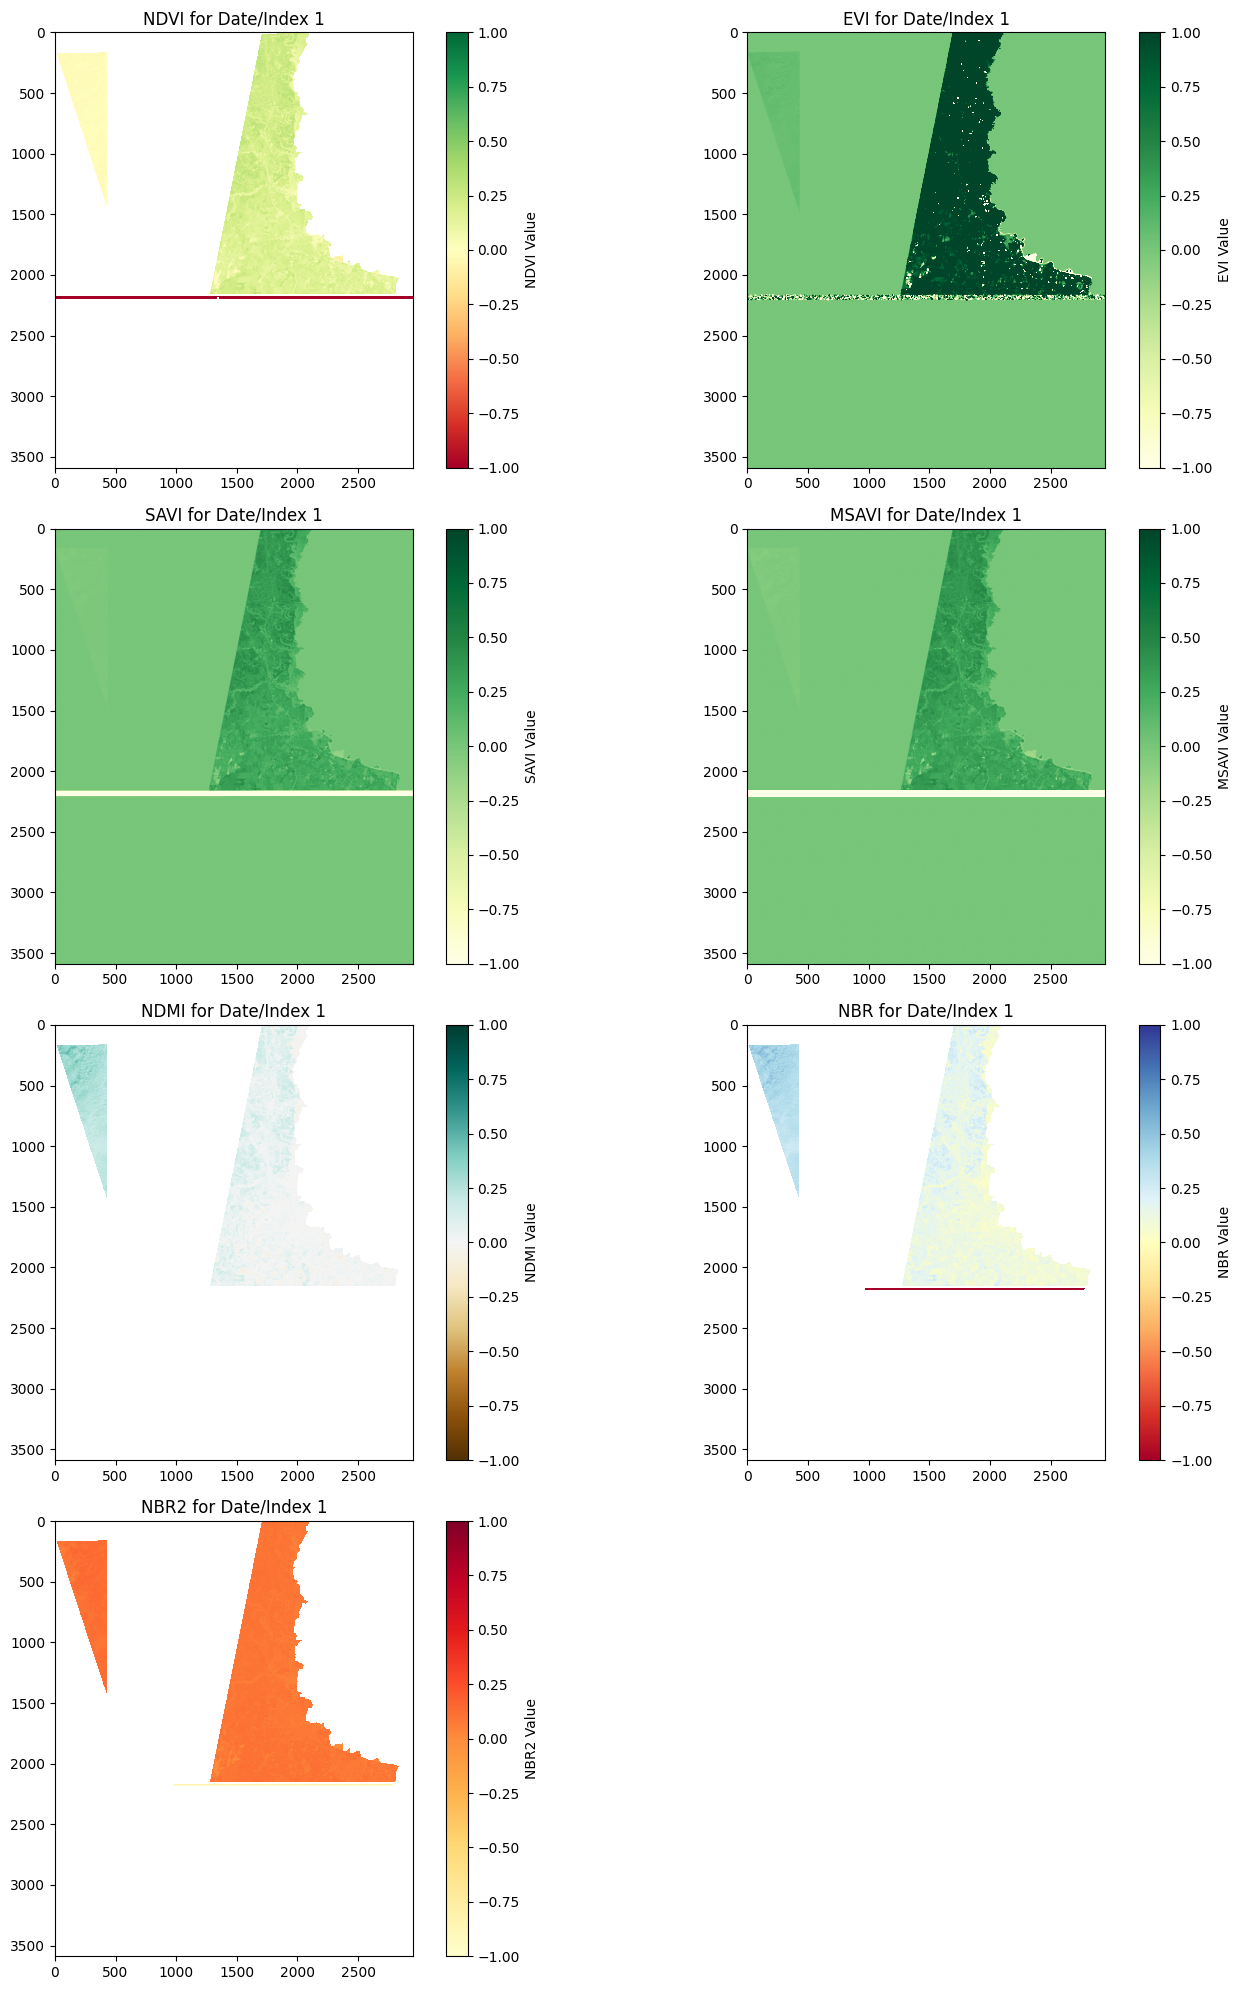

Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: B4_2.tif, B5_2.tif, B2_2.tif, B6_2.tif, and B7_2.tif
Mean NDVI for 2: 0.2322
Standard Deviation of NDVI for 2: 0.0959
Mean EVI for 2: nan
Standard Deviation of EVI for 2: nan
Mean SAVI for 2: 0.0903
Standard Deviation of SAVI for 2: 0.1693
Mean MSAVI for 2: 0.0948
Standard Deviation of MSAVI for 2: 0.1766
Mean NDMI for 2: 0.0710
Standard Deviation of NDMI for 2: 0.0610
Mean NBR for 2: 0.1824
Standard Deviation of NBR for 2: 0.0756
Mean NBR2 for 2: 0.1136
Standard Deviation of NBR2 for 2: 0.0356


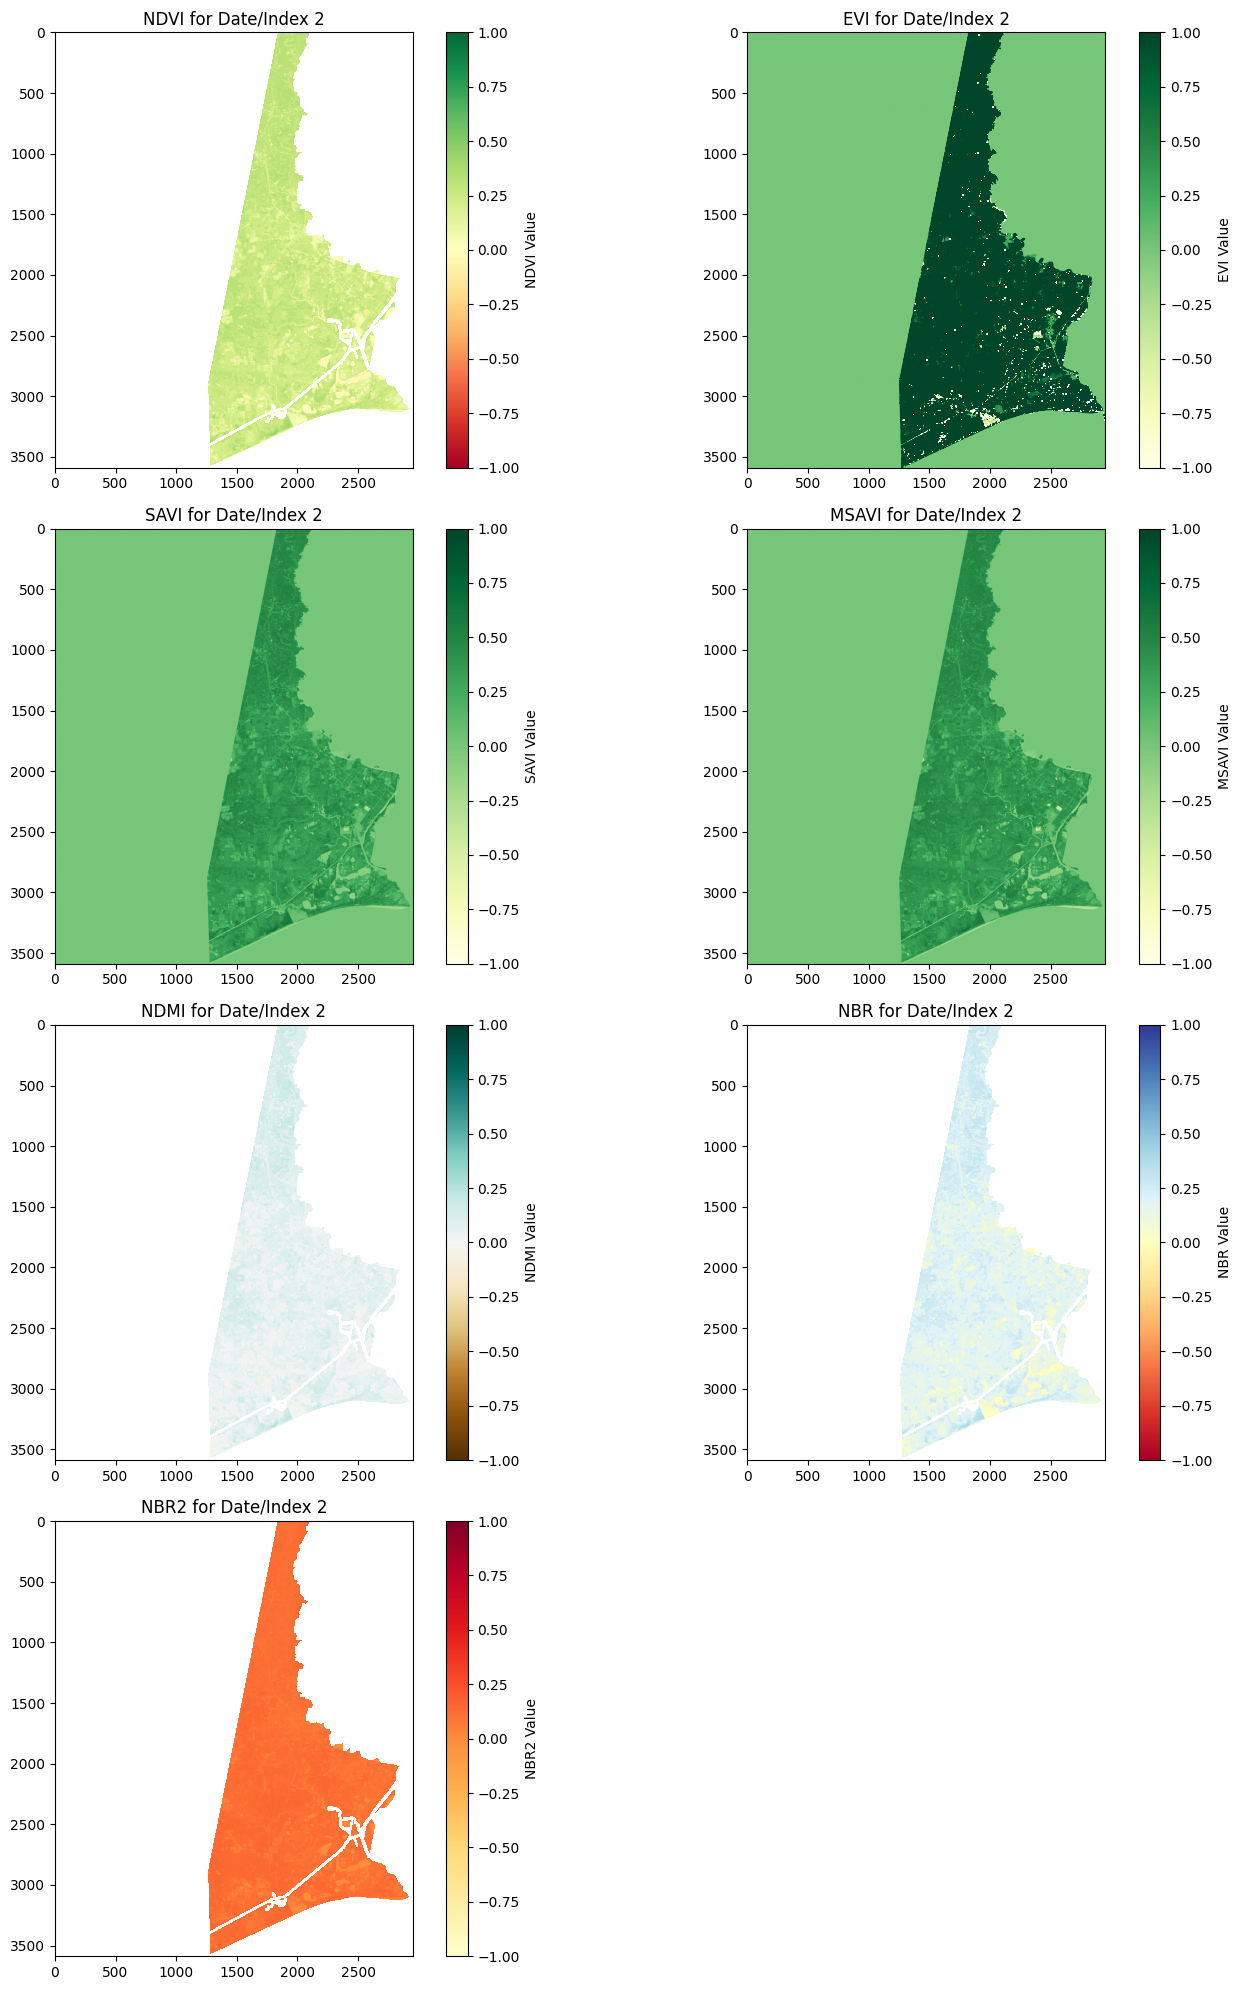

In [64]:
# Define Functions
def calculate_ndvi(band4, band5):
    return (band5 - band4) / (band5 + band4)

def calculate_evi(band4, band5, band2):
    return 2.5 * (band5 - band4) / (band5 + 6 * band4 - 7.5 * band2 + 1)

def calculate_savi(band4, band5):
    return (band5 - band4) / (band5 + band4 + 0.5) * 1.5

def calculate_msavi(band4, band5):
    return (2 * band5 + 1 - np.sqrt((2 * band5 + 1) ** 2 - 8 * (band5 - band4))) / 2

def calculate_ndmi(band5, band6):
    return (band5 - band6) / (band5 + band6)

def calculate_nbr(band5, band7):
    return (band5 - band7) / (band5 + band7)

def calculate_nbr2(band6, band7):
    return (band6 - band7) / (band6 + band7)

# Load the Band 4 (Red), Band 5 (NIR), Band 2 (Blue), Band 6 (SWIR), and Band 7 (SWIR) tif files
band4_files = glob.glob('*B4_*.tif')  
band5_files = glob.glob('*B5_*.tif') 
band2_files = glob.glob('*B2_*.tif')  
band6_files = glob.glob('*B6_*.tif')  
band7_files = glob.glob('*B7_*.tif')  

# Ensure that the corresponding Band 4, Band 5, Band 2, Band 6, and Band 7 files exist for each date/index
for b4_file in band4_files:
    date_index = b4_file.split('_')[1].replace('.tif', '')
    b5_file = f'B5_{date_index}.tif'  
    b2_file = f'B2_{date_index}.tif'  
    b6_file = f'B6_{date_index}.tif'  
    b7_file = f'B7_{date_index}.tif' 

    if b5_file in band5_files and b2_file in band2_files and b6_file in band6_files and b7_file in band7_files:
        print(f"Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: {b4_file}, {b5_file}, {b2_file}, {b6_file}, and {b7_file}")
        
        with rasterio.open(b4_file) as src_b4:
            band4 = src_b4.read(1).astype(float)  
        
        with rasterio.open(b5_file) as src_b5:
            band5 = src_b5.read(1).astype(float)  
        
        with rasterio.open(b2_file) as src_b2:
            band2 = src_b2.read(1).astype(float) 
        
        with rasterio.open(b6_file) as src_b6:
            band6 = src_b6.read(1).astype(float)  
        
        with rasterio.open(b7_file) as src_b7:
            band7 = src_b7.read(1).astype(float)  
        
        # Calculate NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2
        ndvi = calculate_ndvi(band4, band5)
        evi = calculate_evi(band4, band5, band2)
        savi = calculate_savi(band4, band5)
        msavi = calculate_msavi(band4, band5)
        ndmi = calculate_ndmi(band5, band6)
        nbr = calculate_nbr(band5, band7)
        nbr2 = calculate_nbr2(band6, band7)
        
        # Calculate mean and standard deviation of the indices
        ndvi_mean = np.nanmean(ndvi)
        ndvi_std = np.nanstd(ndvi)
        
        evi_mean = np.nanmean(evi)
        evi_std = np.nanstd(evi)
        
        savi_mean = np.nanmean(savi)
        savi_std = np.nanstd(savi)
        
        msavi_mean = np.nanmean(msavi)
        msavi_std = np.nanstd(msavi)
        
        ndmi_mean = np.nanmean(ndmi)
        ndmi_std = np.nanstd(ndmi)
        
        nbr_mean = np.nanmean(nbr)
        nbr_std = np.nanstd(nbr)
        
        nbr2_mean = np.nanmean(nbr2)
        nbr2_std = np.nanstd(nbr2)
        
        # Print the calculated means and standard deviations
        print(f"Mean NDVI for {date_index}: {ndvi_mean:.4f}")
        print(f"Standard Deviation of NDVI for {date_index}: {ndvi_std:.4f}")
        print(f"Mean EVI for {date_index}: {evi_mean:.4f}")
        print(f"Standard Deviation of EVI for {date_index}: {evi_std:.4f}")
        print(f"Mean SAVI for {date_index}: {savi_mean:.4f}")
        print(f"Standard Deviation of SAVI for {date_index}: {savi_std:.4f}")
        print(f"Mean MSAVI for {date_index}: {msavi_mean:.4f}")
        print(f"Standard Deviation of MSAVI for {date_index}: {msavi_std:.4f}")
        print(f"Mean NDMI for {date_index}: {ndmi_mean:.4f}")
        print(f"Standard Deviation of NDMI for {date_index}: {ndmi_std:.4f}")
        print(f"Mean NBR for {date_index}: {nbr_mean:.4f}")
        print(f"Standard Deviation of NBR for {date_index}: {nbr_std:.4f}")
        print(f"Mean NBR2 for {date_index}: {nbr2_mean:.4f}")
        print(f"Standard Deviation of NBR2 for {date_index}: {nbr2_std:.4f}")
        
        # Plot NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 results as subplots
        fig, axs = plt.subplots(4, 2, figsize=(14, 20))
        
        # Create a list of the indices and their respective subplots
        indices = [(ndvi, 'NDVI', 'RdYlGn', -1, 1),
                   (evi, 'EVI', 'YlGn', -1, 1),
                   (savi, 'SAVI', 'YlGn', -1, 1),
                   (msavi, 'MSAVI', 'YlGn', -1, 1),
                   (ndmi, 'NDMI', 'BrBG', -1, 1),
                   (nbr, 'NBR', 'RdYlBu', -1, 1),
                   (nbr2, 'NBR2', 'YlOrRd', -1, 1)]
        
        # Plot each index in its corresponding subplot
        for i, (index, title, cmap, vmin, vmax) in enumerate(indices):
            row, col = divmod(i, 2)
            im = axs[row, col].imshow(index, cmap=cmap, vmin=vmin, vmax=vmax)
            axs[row, col].set_title(f'{title} for Date/Index {date_index}')
            fig.colorbar(im, ax=axs[row, col], label=f'{title} Value')
        
        # Hide any unused subplots
        for j in range(i + 1, 8):  # Hide remaining subplots if there are fewer than 7 indices
            row, col = divmod(j, 2)
            axs[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

<H1>Calculation Indices for Summer</H1>

Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: B4_1.tif, B5_1.tif, B2_1.tif, B6_1.tif, and B7_1.tif


C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:3: RuntimeWarning: invalid value encountered in divide
  return (band5 - band4) / (band5 + band4)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:6: RuntimeWarning: divide by zero encountered in divide
  return 2.5 * (band5 - band4) / (band5 + 6 * band4 - 7.5 * band2 + 1)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:15: RuntimeWarning: invalid value encountered in divide
  return (band5 - band6) / (band5 + band6)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:18: RuntimeWarning: invalid value encountered in divide
  return (band5 - band7) / (band5 + band7)
C:\Users\Sushant\AppData\Local\ipykernel_19020\1611498405.py:21: RuntimeWarning: invalid value encountered in divide
  return (band6 - band7) / (band6 + band7)


Mean NDVI for 1: 0.2582
Standard Deviation of NDVI for 1: 0.1042
Mean EVI for 1: nan
Standard Deviation of EVI for 1: nan
Mean SAVI for 1: 0.1077
Standard Deviation of SAVI for 1: 0.1921
Mean MSAVI for 1: 0.1108
Standard Deviation of MSAVI for 1: 0.1944
Mean NDMI for 1: 0.0611
Standard Deviation of NDMI for 1: 0.0935
Mean NBR for 1: 0.1875
Standard Deviation of NBR for 1: 0.1057
Mean NBR2 for 1: 0.1294
Standard Deviation of NBR2 for 1: 0.0398


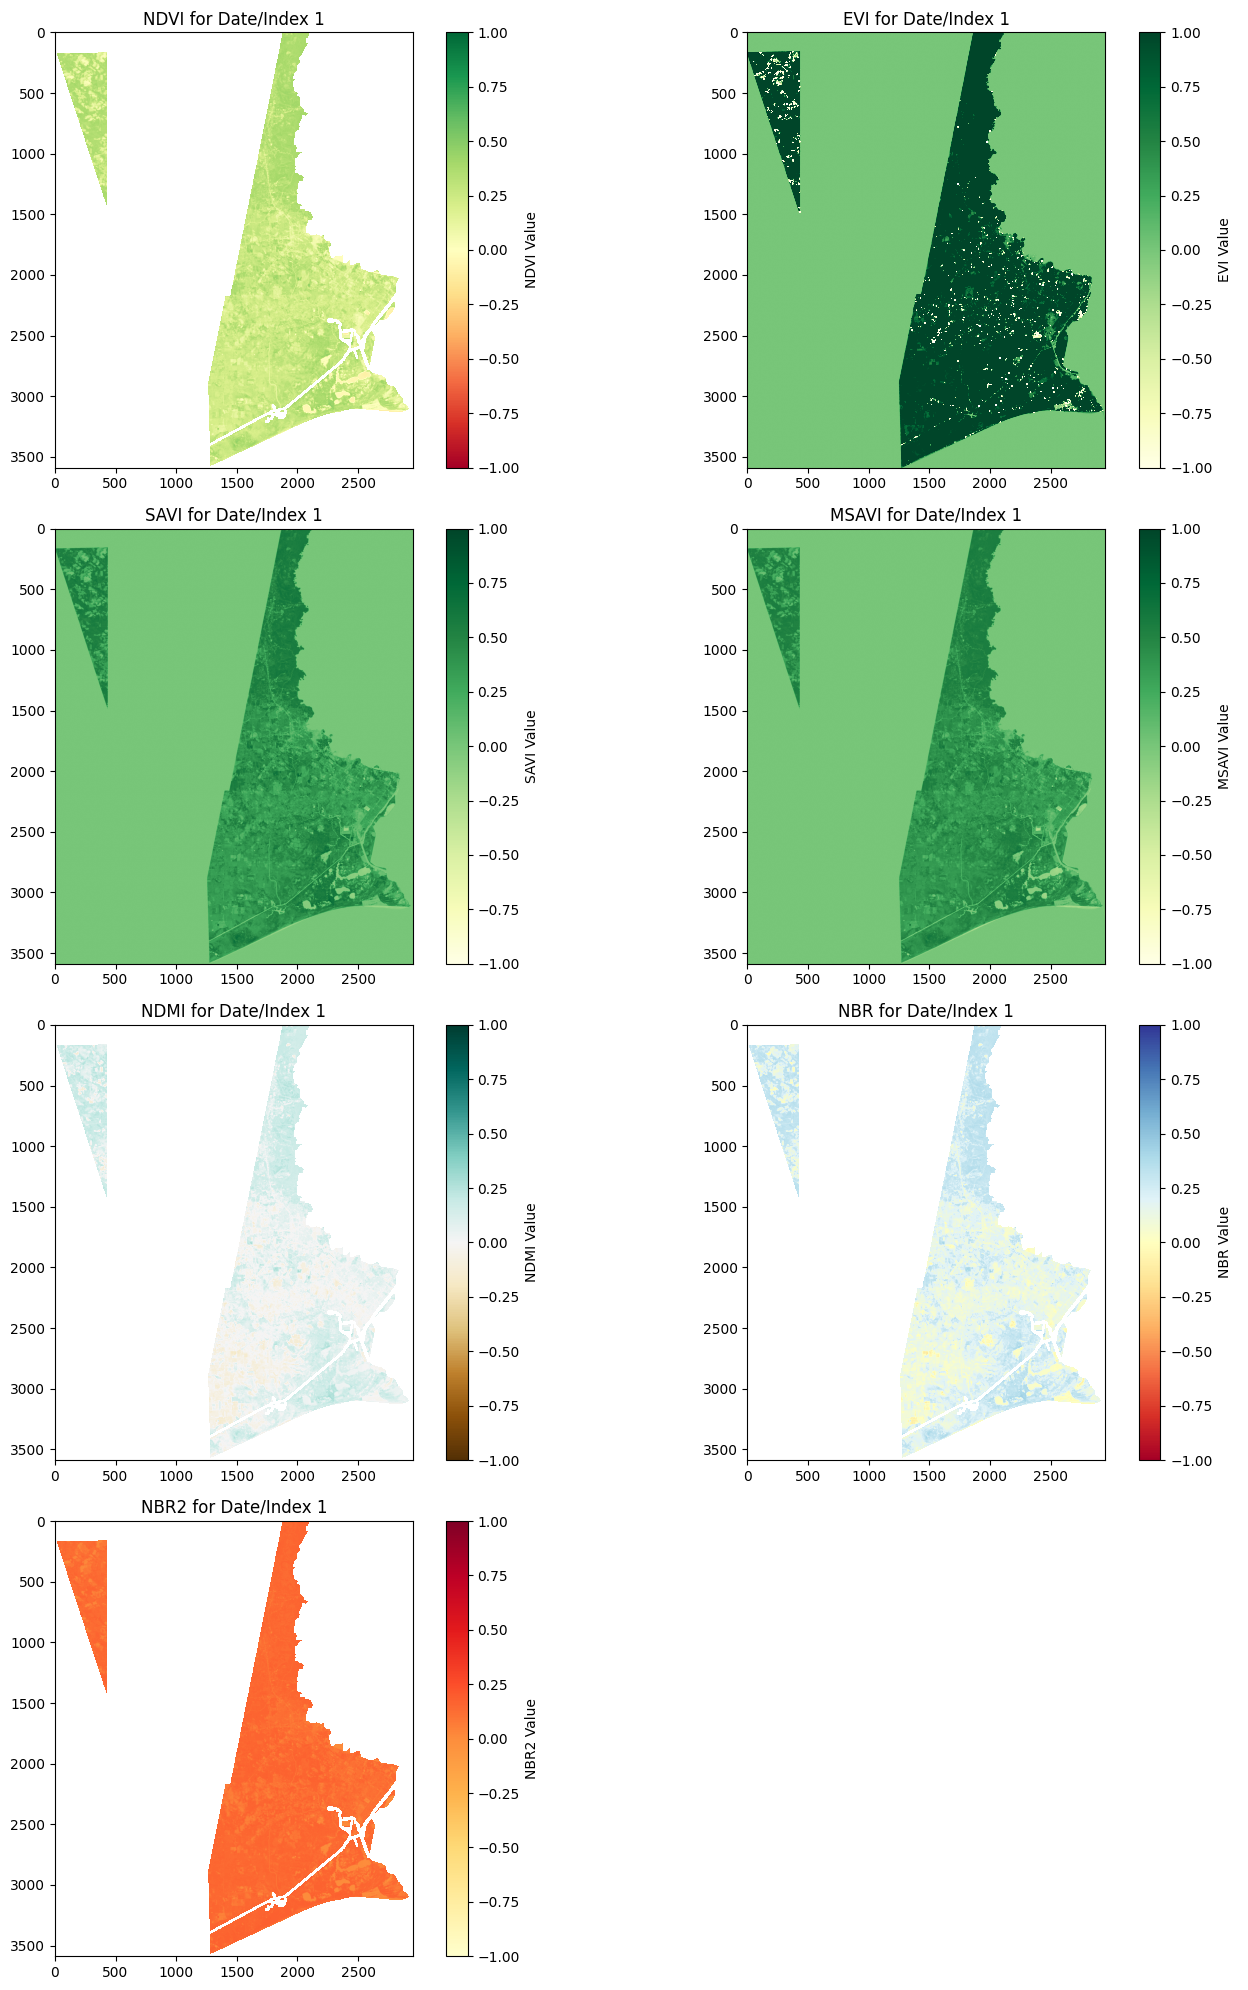

Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: B4_2.tif, B5_2.tif, B2_2.tif, B6_2.tif, and B7_2.tif


C:\Users\Sushant\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


Mean NDVI for 2: 0.3414
Standard Deviation of NDVI for 2: 0.1533
Mean EVI for 2: inf
Standard Deviation of EVI for 2: nan
Mean SAVI for 2: 0.1826
Standard Deviation of SAVI for 2: 0.2811
Mean MSAVI for 2: 0.1641
Standard Deviation of MSAVI for 2: 1.0150
Mean NDMI for 2: 0.1405
Standard Deviation of NDMI for 2: 0.1313
Mean NBR for 2: 0.2789
Standard Deviation of NBR for 2: 0.1627
Mean NBR2 for 2: 0.1441
Standard Deviation of NBR2 for 2: 0.1540


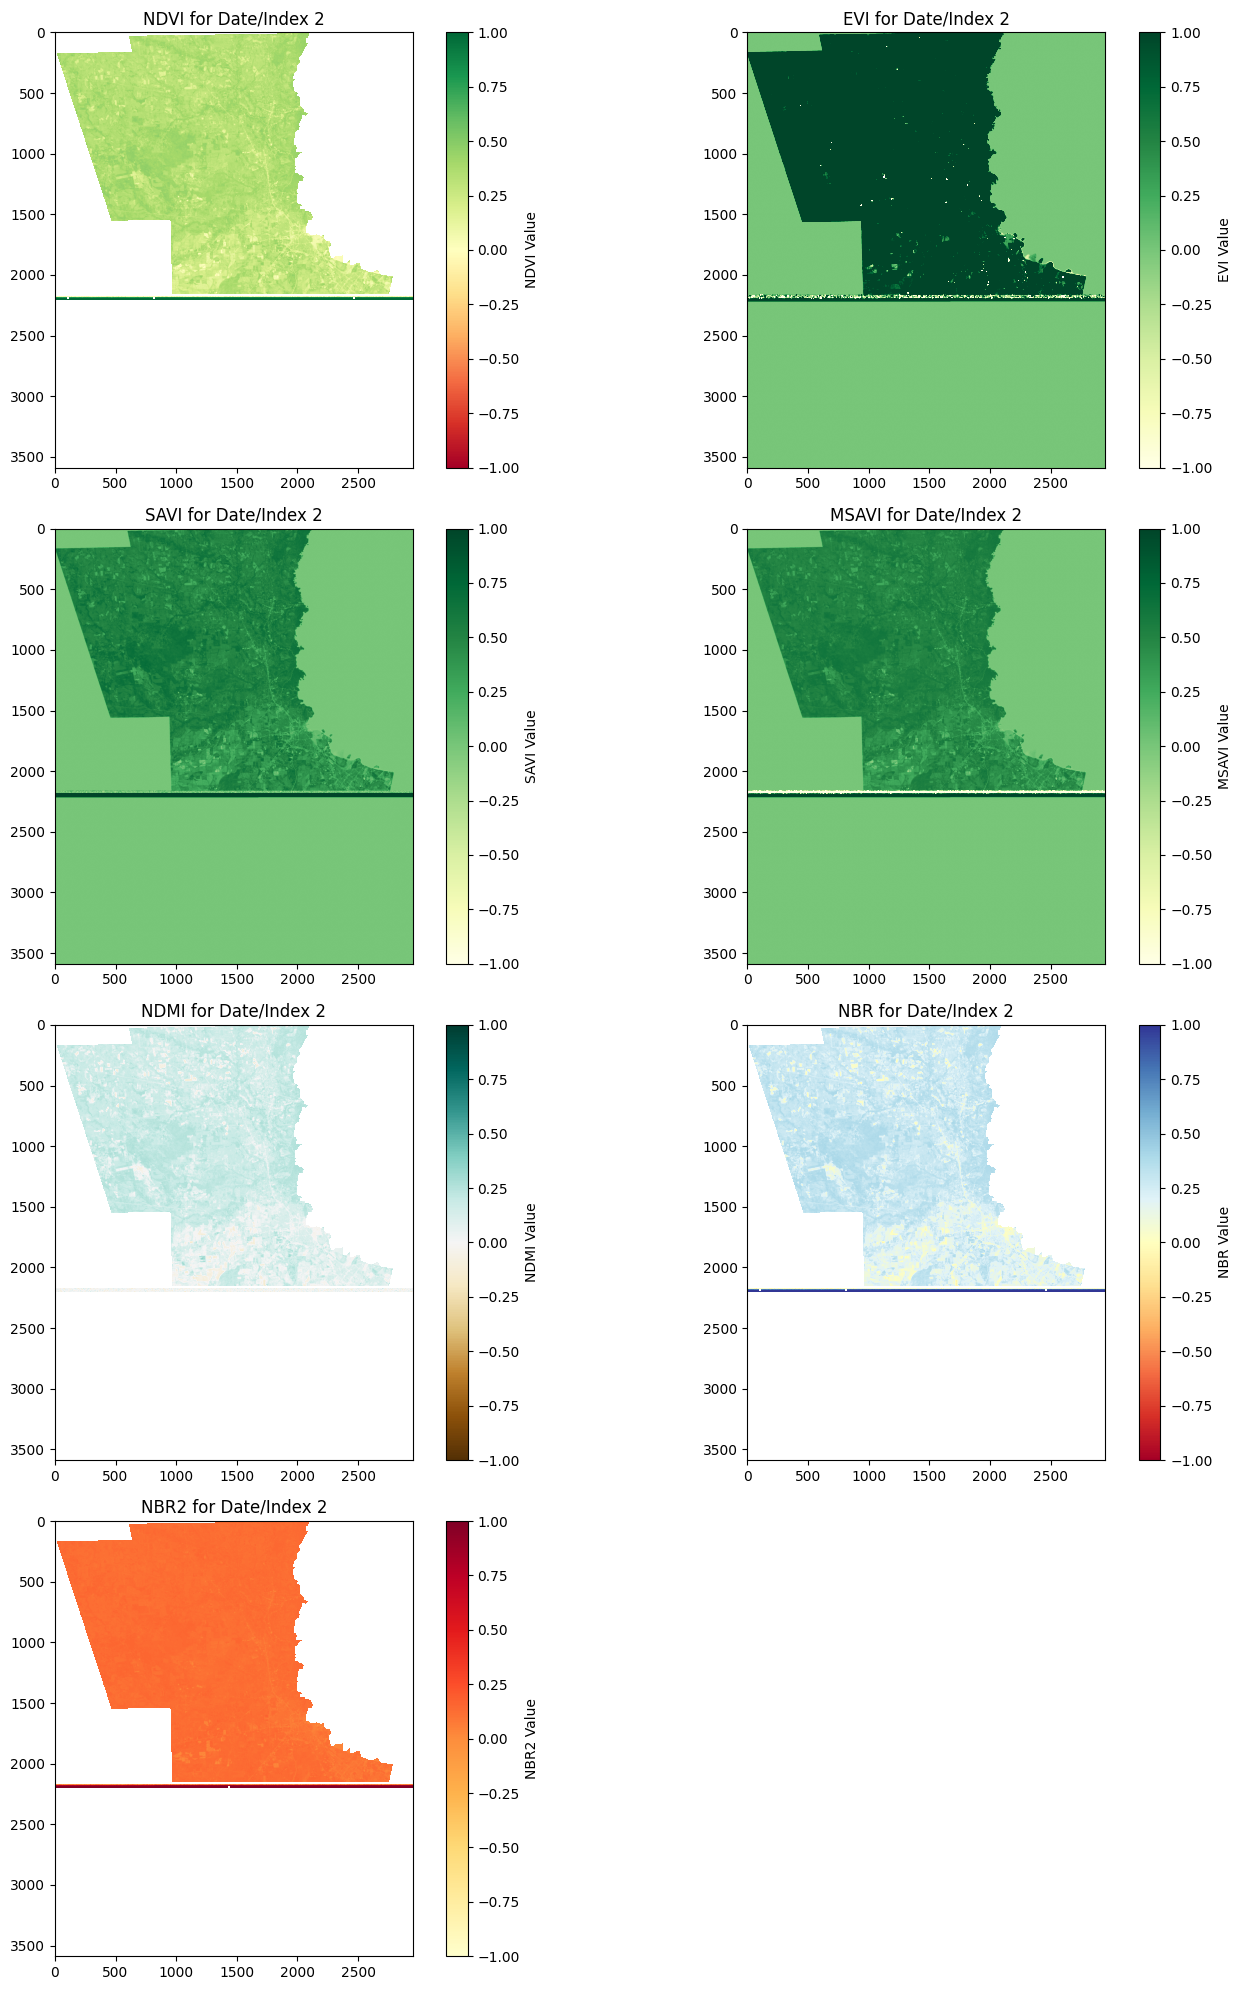

In [65]:
# Define Functions
def calculate_ndvi(band4, band5):
    return (band5 - band4) / (band5 + band4)

def calculate_evi(band4, band5, band2):
    return 2.5 * (band5 - band4) / (band5 + 6 * band4 - 7.5 * band2 + 1)

def calculate_savi(band4, band5):
    return (band5 - band4) / (band5 + band4 + 0.5) * 1.5

def calculate_msavi(band4, band5):
    return (2 * band5 + 1 - np.sqrt((2 * band5 + 1) ** 2 - 8 * (band5 - band4))) / 2

def calculate_ndmi(band5, band6):
    return (band5 - band6) / (band5 + band6)

def calculate_nbr(band5, band7):
    return (band5 - band7) / (band5 + band7)

def calculate_nbr2(band6, band7):
    return (band6 - band7) / (band6 + band7)

# Load the Band 4 (Red), Band 5 (NIR), Band 2 (Blue), Band 6 (SWIR), and Band 7 (SWIR) tif files
band4_files = glob.glob('*B4_*.tif')  
band5_files = glob.glob('*B5_*.tif') 
band2_files = glob.glob('*B2_*.tif')  
band6_files = glob.glob('*B6_*.tif')  
band7_files = glob.glob('*B7_*.tif')  

# Ensure that the corresponding Band 4, Band 5, Band 2, Band 6, and Band 7 files exist for each date/index
for b4_file in band4_files:
    date_index = b4_file.split('_')[1].replace('.tif', '')
    b5_file = f'B5_{date_index}.tif'  
    b2_file = f'B2_{date_index}.tif'  
    b6_file = f'B6_{date_index}.tif'  
    b7_file = f'B7_{date_index}.tif' 

    if b5_file in band5_files and b2_file in band2_files and b6_file in band6_files and b7_file in band7_files:
        print(f"Processing NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 for: {b4_file}, {b5_file}, {b2_file}, {b6_file}, and {b7_file}")
        
        with rasterio.open(b4_file) as src_b4:
            band4 = src_b4.read(1).astype(float)  
        
        with rasterio.open(b5_file) as src_b5:
            band5 = src_b5.read(1).astype(float)  
        
        with rasterio.open(b2_file) as src_b2:
            band2 = src_b2.read(1).astype(float) 
        
        with rasterio.open(b6_file) as src_b6:
            band6 = src_b6.read(1).astype(float)  
        
        with rasterio.open(b7_file) as src_b7:
            band7 = src_b7.read(1).astype(float)  
        
        # Calculate NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2
        ndvi = calculate_ndvi(band4, band5)
        evi = calculate_evi(band4, band5, band2)
        savi = calculate_savi(band4, band5)
        msavi = calculate_msavi(band4, band5)
        ndmi = calculate_ndmi(band5, band6)
        nbr = calculate_nbr(band5, band7)
        nbr2 = calculate_nbr2(band6, band7)
        
        # Calculate mean and standard deviation of the indices
        ndvi_mean = np.nanmean(ndvi)
        ndvi_std = np.nanstd(ndvi)
        
        evi_mean = np.nanmean(evi)
        evi_std = np.nanstd(evi)
        
        savi_mean = np.nanmean(savi)
        savi_std = np.nanstd(savi)
        
        msavi_mean = np.nanmean(msavi)
        msavi_std = np.nanstd(msavi)
        
        ndmi_mean = np.nanmean(ndmi)
        ndmi_std = np.nanstd(ndmi)
        
        nbr_mean = np.nanmean(nbr)
        nbr_std = np.nanstd(nbr)
        
        nbr2_mean = np.nanmean(nbr2)
        nbr2_std = np.nanstd(nbr2)
        
        # Print the calculated means and standard deviations
        print(f"Mean NDVI for {date_index}: {ndvi_mean:.4f}")
        print(f"Standard Deviation of NDVI for {date_index}: {ndvi_std:.4f}")
        print(f"Mean EVI for {date_index}: {evi_mean:.4f}")
        print(f"Standard Deviation of EVI for {date_index}: {evi_std:.4f}")
        print(f"Mean SAVI for {date_index}: {savi_mean:.4f}")
        print(f"Standard Deviation of SAVI for {date_index}: {savi_std:.4f}")
        print(f"Mean MSAVI for {date_index}: {msavi_mean:.4f}")
        print(f"Standard Deviation of MSAVI for {date_index}: {msavi_std:.4f}")
        print(f"Mean NDMI for {date_index}: {ndmi_mean:.4f}")
        print(f"Standard Deviation of NDMI for {date_index}: {ndmi_std:.4f}")
        print(f"Mean NBR for {date_index}: {nbr_mean:.4f}")
        print(f"Standard Deviation of NBR for {date_index}: {nbr_std:.4f}")
        print(f"Mean NBR2 for {date_index}: {nbr2_mean:.4f}")
        print(f"Standard Deviation of NBR2 for {date_index}: {nbr2_std:.4f}")
        
        # Plot NDVI, EVI, SAVI, MSAVI, NDMI, NBR, and NBR2 results as subplots
        fig, axs = plt.subplots(4, 2, figsize=(14, 20))
        
        # Create a list of the indices and their respective subplots
        indices = [(ndvi, 'NDVI', 'RdYlGn', -1, 1),
                   (evi, 'EVI', 'YlGn', -1, 1),
                   (savi, 'SAVI', 'YlGn', -1, 1),
                   (msavi, 'MSAVI', 'YlGn', -1, 1),
                   (ndmi, 'NDMI', 'BrBG', -1, 1),
                   (nbr, 'NBR', 'RdYlBu', -1, 1),
                   (nbr2, 'NBR2', 'YlOrRd', -1, 1)]
        
        # Plot each index in its corresponding subplot
        for i, (index, title, cmap, vmin, vmax) in enumerate(indices):
            row, col = divmod(i, 2)
            im = axs[row, col].imshow(index, cmap=cmap, vmin=vmin, vmax=vmax)
            axs[row, col].set_title(f'{title} for Date/Index {date_index}')
            fig.colorbar(im, ax=axs[row, col], label=f'{title} Value')
        
        # Hide any unused subplots
        for j in range(i + 1, 8):  # Hide remaining subplots if there are fewer than 7 indices
            row, col = divmod(j, 2)
            axs[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

<H1>Pixels staying similar between the two seasons for each index</H1>

C:\Users\Sushant\AppData\Local\ipykernel_19020\2262732611.py:38: RuntimeWarning: invalid value encountered in add
  warm_avg = (warm_season_1 + warm_season_2) / 2


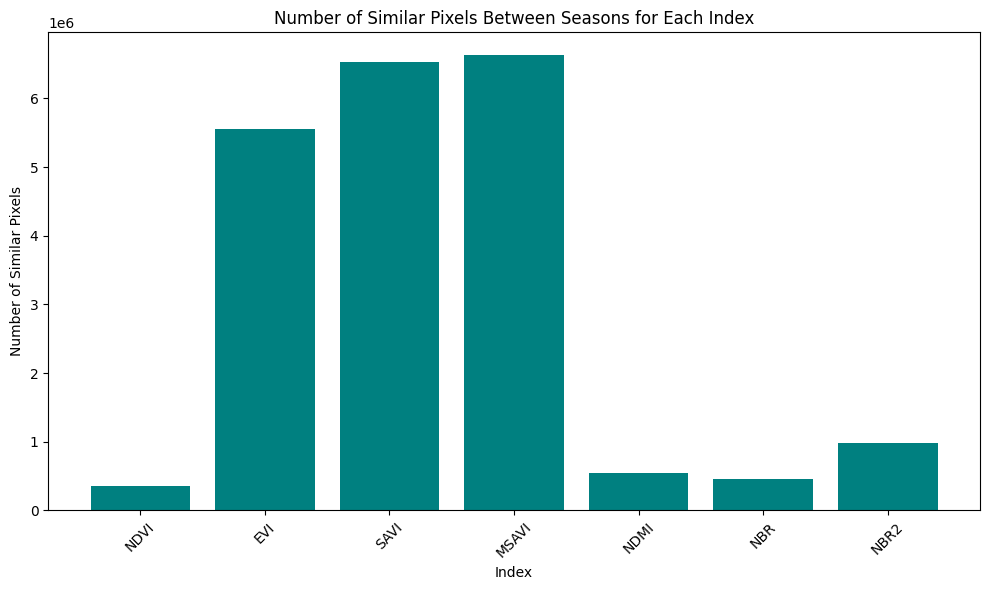

NDVI: 356962 similar pixels
EVI: 5557742 similar pixels
SAVI: 6523818 similar pixels
MSAVI: 6630387 similar pixels
NDMI: 543718 similar pixels
NBR: 455651 similar pixels
NBR2: 981781 similar pixels


In [52]:
#Define Functions
def read_tif(file):
    with rasterio.open(file) as src:
        return src.read(1)  # Read the first band

def calculate_similar_pixels(image1, image2, threshold=0.05):
    diff = np.abs(image1 - image2)
    similar_pixels = np.sum(diff < threshold)
    return similar_pixels

# List of index names and their corresponding tif files
indices = ['NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDMI', 'NBR', 'NBR2']
files = {
    'NDVI': ['NDVI_1.tif', 'NDVI_2.tif', 'NDVI_3.tif', 'NDVI_4.tif'],
    'EVI': ['EVI_1.tif', 'EVI_2.tif', 'EVI_3.tif', 'EVI_4.tif'],
    'SAVI': ['SAVI_1.tif', 'SAVI_2.tif', 'SAVI_3.tif', 'SAVI_4.tif'],
    'MSAVI': ['MSAVI_1.tif', 'MSAVI_2.tif', 'MSAVI_3.tif', 'MSAVI_4.tif'],
    'NDMI': ['NDMI_1.tif', 'NDMI_2.tif', 'NDMI_3.tif', 'NDMI_4.tif'],
    'NBR': ['NBR_1.tif', 'NBR_2.tif', 'NBR_3.tif', 'NBR_4.tif'],
    'NBR2': ['NBR2_1.tif', 'NBR2_2.tif', 'NBR2_3.tif', 'NBR2_4.tif']
}

# Initialize a dictionary to store results
similar_pixel_counts = {}
for index in indices:
    # Read the warm and cold season files
    warm_season_1 = read_tif(files[index][0])  
    warm_season_2 = read_tif(files[index][1])  
    cold_season_1 = read_tif(files[index][2])  
    cold_season_2 = read_tif(files[index][3])  
    
    warm_avg = (warm_season_1 + warm_season_2) / 2
    cold_avg = (cold_season_1 + cold_season_2) / 2
    similar_pixels = calculate_similar_pixels(warm_avg, cold_avg)
    similar_pixel_counts[index] = similar_pixels

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(similar_pixel_counts.keys(), similar_pixel_counts.values(), color='teal')
plt.title('Number of Similar Pixels Between Seasons for Each Index')
plt.xlabel('Index')
plt.ylabel('Number of Similar Pixels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print
for index, count in similar_pixel_counts.items():
    print(f"{index}: {count} similar pixels")

<H1>Average difference between the two seasons</H1>

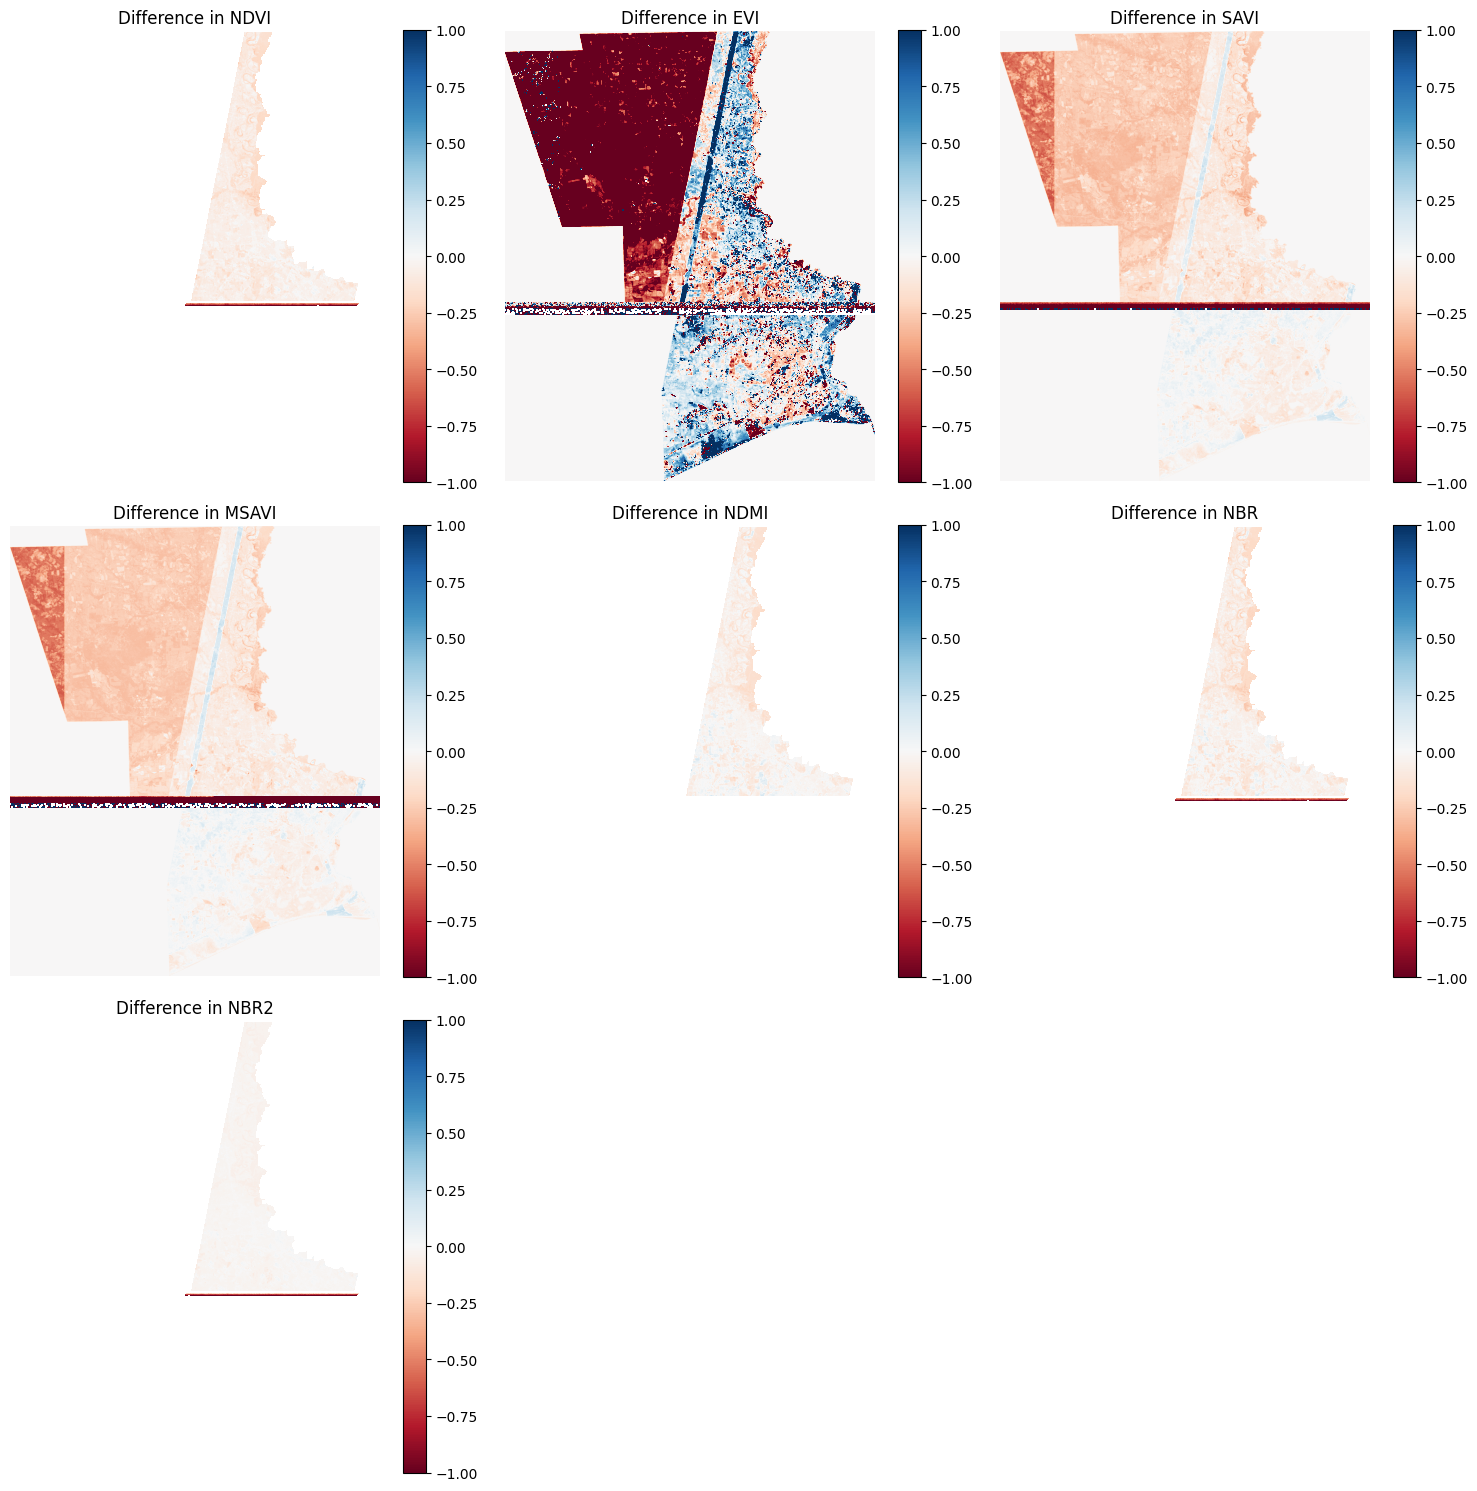

In [56]:
# Function to read a tif file and return its data as a numpy array
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)  

# List of index names for easier reference
indices = ['NDVI', 'EVI', 'SAVI', 'MSAVI', 'NDMI', 'NBR', 'NBR2']
file_paths = {
    'NDVI': ['NDVI_1.tif', 'NDVI_2.tif', 'NDVI_3.tif', 'NDVI_4.tif'],
    'EVI': ['EVI_1.tif', 'EVI_2.tif', 'EVI_3.tif', 'EVI_4.tif'],
    'SAVI': ['SAVI_1.tif', 'SAVI_2.tif', 'SAVI_3.tif', 'SAVI_4.tif'],
    'MSAVI': ['MSAVI_1.tif', 'MSAVI_2.tif', 'MSAVI_3.tif', 'MSAVI_4.tif'],
    'NDMI': ['NDMI_1.tif', 'NDMI_2.tif', 'NDMI_3.tif', 'NDMI_4.tif'],
    'NBR': ['NBR_1.tif', 'NBR_2.tif', 'NBR_3.tif', 'NBR_4.tif'],
    'NBR2': ['NBR2_1.tif', 'NBR2_2.tif', 'NBR2_3.tif', 'NBR2_4.tif']
}


def calculate_difference(index_name, file_paths):
    warm_season = np.mean([read_raster(fp) for fp in file_paths[:2]], axis=0)
    cold_season = np.mean([read_raster(fp) for fp in file_paths[2:]], axis=0)
    difference = cold_season - warm_season
    return difference

# Plot all differences in subplots
def plot_all_differences(indices, file_paths):
    num_plots = len(indices)
    cols = 3  
    rows = (num_plots // cols) + (num_plots % cols > 0)  
    
    # Create the figure and axes for subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten axes array for easy indexing

    for i, index in enumerate(indices):
        difference = calculate_difference(index, file_paths[index])
        
        # Plot the difference on the current subplot
        ax = axes[i]
        cax = ax.imshow(difference, cmap='RdBu', vmin=-1, vmax=1)
        ax.set_title(f'Difference in {index}')
        ax.axis('off')
        fig.colorbar(cax, ax=ax)

    # Hide any unused subplots (if there are fewer indices than subplot positions)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot all differences in subplots
plot_all_differences(indices, file_paths)